<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/vae_celeba_mnist_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Import Pytorch and other libraries

In [1]:
import os
import time
import numpy as np
np.random.seed(0)
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

import sklearn
from sklearn import metrics

import seaborn as sns;
sns.set(style="ticks", color_codes=True)

import pandas as pd
pd.set_option('precision', 2) # 2 decimal places
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100) # wide windows


In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchvision.utils import make_grid
from random import randint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def save_loss_plot(train_loss, valid_loss):
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/content/outputs/loss.jpg')
    plt.show()


In [4]:
!mkdir ./outputs

# Load CelebA

Here we download a zipfile of images and their attributes
that have been preprocessed to 64x64 using the script at
https://github.com/probml/pyprobml/blob/master/scripts/celeba_kaggle_preprocess.py



In [5]:
# N can be 200, 20000, or 40000
N = 20000
H = 64; W = 64; C = 3;
input_shape = [H, W, 3]
name = 'celeba_small_H{}_W{}_N{}'.format(H, W, N)
csv_name = '{}.csv'.format(name)
zip_name = '{}.zip'.format(name)

In [6]:
!rm {csv_name}
!wget https://raw.githubusercontent.com/probml/pyprobml/master/data/CelebA/{csv_name}  

rm: cannot remove 'celeba_small_H64_W64_N20000.csv': No such file or directory
--2021-05-11 06:00:50--  https://raw.githubusercontent.com/probml/pyprobml/master/data/CelebA/celeba_small_H64_W64_N20000.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2440084 (2.3M) [text/plain]
Saving to: ‘celeba_small_H64_W64_N20000.csv’

celeba_small_H64_W6 100%[===================>]   2.33M  --.-KB/s    in 0.1s    

2021-05-11 06:00:51 (18.5 MB/s) - ‘celeba_small_H64_W64_N20000.csv’ saved [2440084/2440084]



In [7]:
df = pd.read_csv(csv_name)
df.head()


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,...,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [8]:
print(list(df.columns))

['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [9]:
N = len(df)
print(N)

20000


In [10]:
!rm {zip_name}
!wget https://raw.githubusercontent.com/probml/pyprobml/master/data/CelebA/{zip_name}
  

rm: cannot remove 'celeba_small_H64_W64_N20000.zip': No such file or directory
--2021-05-11 06:00:51--  https://raw.githubusercontent.com/probml/pyprobml/master/data/CelebA/celeba_small_H64_W64_N20000.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34148268 (33M) [application/zip]
Saving to: ‘celeba_small_H64_W64_N20000.zip’

celeba_small_H64_W6 100%[===================>]  32.57M  58.7MB/s    in 0.6s    

2021-05-11 06:00:55 (58.7 MB/s) - ‘celeba_small_H64_W64_N20000.zip’ saved [34148268/34148268]



In [11]:
!rm *.jpg
!ls

rm: cannot remove '*.jpg': No such file or directory
celeba_small_H64_W64_N20000.csv  outputs
celeba_small_H64_W64_N20000.zip  sample_data


In [12]:
!unzip -qq {zip_name}

In [13]:
from glob import glob
filenames = glob('*.jpg')
#print(filenames) # should match df['image_id']
print(len(filenames))

20000


In [14]:
from matplotlib.image import imread
images_celeba = np.zeros((N, H, W, C), dtype=np.float32) # pre-allocate memory
for i in range(N):
    filename = df.iloc[i]['image_id']
    img = imread(filename) # numpy array of uint8
    images_celeba[i,:,:,:] = img / 255

In [15]:
class Celeba_ds(Dataset):

  def __init__(self, images):
    self.X = images

  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, index):
        image = self.X[index]
        X = self.transform(image)
        return X
  
  transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        ])

# annotated.
class Celeba_ano_ds(Dataset):

  def __init__(self, images, labels):
    self.X = images
    self.labels = labels

  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, index):
        image = self.X[index]
        label = self.labels[index]
        X = self.transform(image)
        sample = (X,label)
        return sample
  
  transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        ])


In [16]:
celeba_dataset = Celeba_ds(images_celeba)
celeba_train_loader = DataLoader(
        celeba_dataset,batch_size= 32,shuffle=False)

celeba_test_loader = celeba_train_loader


# Load Mnist

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
])
# training set and train data loader
mnist_trainset = torchvision.datasets.MNIST(
    root='../input', train=True, download=True, transform=transform
)
mnist_trainloader = DataLoader(
    mnist_trainset, batch_size=32, shuffle=True
)
# validation set and validation data loader
mnist_testset = torchvision.datasets.MNIST(
    root='../input', train=False, download=True, transform=transform
)
mnist_testloader = DataLoader(
    mnist_testset, batch_size=32, shuffle=False
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../input/MNIST/raw/train-images-idx3-ubyte.gz to ../input/MNIST/raw




Extracting ../input/MNIST/raw/train-labels-idx1-ubyte.gz to ../input/MNIST/raw




Extracting ../input/MNIST/raw/t10k-images-idx3-ubyte.gz to ../input/MNIST/raw




Extracting ../input/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../input/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Model

In [18]:
def final_loss(bce_loss, mu=None, logvar=None):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss
    if logvar==None:
      KLD = 0
    else:
      KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [19]:
def train(model, dataloader, dataset, device, optimizer, criterion, callback=None, labeled=False):
    model.train()
    running_loss = 0.0
    counter = 0
    r = randint(0,int(len(dataset)/dataloader.batch_size)-1)
    for i, data in enumerate(dataloader):
        counter += 1
        if labeled:
          data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        # save the last batch input and output of every epoch
        if i == r:
            recon_images = reconstruction
            images = data
    train_loss = running_loss / counter 
    return train_loss,images,recon_images

In [20]:
def validate(model, dataloader, dataset, device, criterion,labeled=False):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            counter += 1
            if labeled:
              data = data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
    val_loss = running_loss / counter
    return val_loss

In [21]:
from torchsummary import summary

In [22]:
# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self,input_shape,
                      encoder_conv_filters,
                      decoder_conv_t_filters,
                      latent_dim,
                      model_name,
                      deterministic=False):
        super(ConvVAE, self).__init__()
        self.input_shape = input_shape

        self.latent_dim = latent_dim
        self.model_name = model_name
        self.deterministic = deterministic

        all_channels = [self.input_shape[0]] + encoder_conv_filters
        
        self.enc_convs = nn.ModuleList([])

        #encoder_conv_layers
        for i in range(len(encoder_conv_filters)):
          self.enc_convs.append(nn.Conv2d(all_channels[i], all_channels[i+1],
                                     kernel_size=3, stride=2, padding=1))
          if not self.latent_dim == 2:
            self.enc_convs.append(nn.BatchNorm2d(all_channels[i+1]))
          self.enc_convs.append(nn.LeakyReLU())
        
        self.flatten_out_size = self.flatten_enc_out_shape(input_shape)
        
        if self.latent_dim == 2:
          self.mu_linear = nn.Linear(self.flatten_out_size, self.latent_dim)
        else:
          self.mu_linear = nn.Sequential(
              nn.Linear(self.flatten_out_size, self.latent_dim),
              nn.LeakyReLU(),
              nn.Dropout(0.2)
          )

        if self.latent_dim == 2:
          self.log_var_linear = nn.Linear(self.flatten_out_size, self.latent_dim)
        else:
          self.log_var_linear = nn.Sequential(
              nn.Linear(self.flatten_out_size, self.latent_dim),
              nn.LeakyReLU(),
              nn.Dropout(0.2)
          )

        if self.latent_dim == 2:
          self.decoder_linear = nn.Linear(self.latent_dim, self.flatten_out_size)
        else:
          self.decoder_linear = nn.Sequential(
              nn.Linear(self.latent_dim, self.flatten_out_size),
              nn.LeakyReLU(),
              nn.Dropout(0.2)
          )

        all_t_channels = [encoder_conv_filters[-1]] + decoder_conv_t_filters 
        
        self.dec_t_convs = nn.ModuleList([])

        num = len(decoder_conv_t_filters)

        #decoder_trans_conv_layers
        for i in range(num-1):
          self.dec_t_convs.append(nn.UpsamplingNearest2d(scale_factor=2))
          self.dec_t_convs.append(nn.ConvTranspose2d(all_t_channels[i], all_t_channels[i+1],
                                                     3, stride=1, padding=1))
          if not self.latent_dim == 2:
            self.dec_t_convs.append(nn.BatchNorm2d(all_t_channels[i+1]))
          self.dec_t_convs.append(nn.LeakyReLU())
        
        self.dec_t_convs.append(nn.UpsamplingNearest2d(scale_factor=2))
        self.dec_t_convs.append(nn.ConvTranspose2d(all_t_channels[num-1], all_t_channels[num],
                                                     3, stride=1, padding=1))
        self.dec_t_convs.append(nn.Sigmoid())
        

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var)# standard deviation
        eps = torch.randn_like(std).to(device) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample

    def flatten_enc_out_shape(self,input_shape):
      x = torch.zeros(1,*input_shape)
      for l in self.enc_convs:
        x = l(x)
      self.shape_before_flattening = x.shape
      return int(np.prod(self.shape_before_flattening))
      
    def encode(self, x):
        for l in self.enc_convs:
          x = l(x)
        x = x.to(device)
        x = x.view(x.size()[0], -1)
        mu = self.mu_linear(x)
        log_var = self.log_var_linear(x)
        return mu, log_var
    
    def decode(self,z):
        z = self.decoder_linear(z)
        recon = z.view(z.size()[0], *self.shape_before_flattening[1:])
        for l in self.dec_t_convs:
          recon = l(recon)
        recon = recon.to(device)
        return recon

    def forward(self, x):
        if self.deterministic:
          return self.det_forward(x)
        else:
          mu, log_var = self.encode(x)
          z = self.reparameterize(mu,log_var)
          recon = self.decode(z)
          return recon,mu,log_var

    def det_forward(self, x):
         mu, log_var = self.encode(x)
         recon = self.decode(mu)
         return recon,mu,None

In [23]:
encoder_conv_filters=[32,64,64, 64]
decoder_conv_t_filters=[64,64,32,3]
Xsmall = next(iter(celeba_train_loader))[0,:]
models_celeba = {}
models_celeba['200d-stoch'] = ConvVAE(Xsmall.shape,encoder_conv_filters,decoder_conv_t_filters,200,'200d-stoch').to(device)
models_celeba['200d-det'] = ConvVAE(Xsmall.shape,encoder_conv_filters,decoder_conv_t_filters,200,'200d-det',True).to(device)
summary(models_celeba['200d-det'],Xsmall.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
       BatchNorm2d-2           [-1, 32, 16, 16]              64
         LeakyReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
       BatchNorm2d-5             [-1, 64, 8, 8]             128
         LeakyReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 4, 4]          36,928
       BatchNorm2d-8             [-1, 64, 4, 4]             128
         LeakyReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 2, 2]          36,928
      BatchNorm2d-11             [-1, 64, 2, 2]             128
        LeakyReLU-12             [-1, 64, 2, 2]               0
           Linear-13                  [-1, 200]          51,400
        LeakyReLU-14                  [

In [24]:
encoder_conv_filters=[32,64,64]
decoder_conv_t_filters=[64,32,1]
Xsmall = next(iter(mnist_trainloader))[0][0,:]
models_mnist = {}
models_mnist['200d-stoch'] = ConvVAE(Xsmall.shape,encoder_conv_filters,decoder_conv_t_filters,200,'200d-stoch').to(device)
models_mnist['200d-det'] = ConvVAE(Xsmall.shape,encoder_conv_filters,decoder_conv_t_filters,200,'200d-det',True).to(device)
summary(models_mnist['200d-det'],Xsmall.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
       BatchNorm2d-2           [-1, 32, 16, 16]              64
         LeakyReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
       BatchNorm2d-5             [-1, 64, 8, 8]             128
         LeakyReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 4, 4]          36,928
       BatchNorm2d-8             [-1, 64, 4, 4]             128
         LeakyReLU-9             [-1, 64, 4, 4]               0
           Linear-10                  [-1, 200]         205,000
        LeakyReLU-11                  [-1, 200]               0
          Dropout-12                  [-1, 200]               0
           Linear-13                  [-1, 200]         205,000
        LeakyReLU-14                  [

In [25]:
encoder_conv_filters=[32,64,64, 64]
decoder_conv_t_filters=[64,64,32,1]
Xsmall = next(iter(mnist_trainloader))[0][0,:]
models_mnist['2d-det'] = ConvVAE(Xsmall.shape,encoder_conv_filters,decoder_conv_t_filters,2,'2d-det',True).to(device)
models_mnist['2d-stoch'] = ConvVAE(Xsmall.shape,encoder_conv_filters,decoder_conv_t_filters,2,'2d-stoch').to(device)
summary(models_mnist['2d-det'],Xsmall.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
         LeakyReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
         LeakyReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 4, 4]          36,928
         LeakyReLU-6             [-1, 64, 4, 4]               0
            Conv2d-7             [-1, 64, 2, 2]          36,928
         LeakyReLU-8             [-1, 64, 2, 2]               0
            Linear-9                    [-1, 2]             514
           Linear-10                    [-1, 2]             514
           Linear-11                  [-1, 256]             768
UpsamplingNearest2d-12             [-1, 64, 4, 4]               0
  ConvTranspose2d-13             [-1, 64, 4, 4]          36,928
        LeakyReLU-14             [-1,

# Training

In [26]:
mpl.style.use('ggplot')
# set the learning parameters
lr = 0.001
criterion = nn.BCELoss(reduction='sum')

In [27]:

# Callback

# We use fixed noise vector to generate samples during training so
# it will be easier to see the improvement.
num_examples_to_generate = 16
noise_dict = {}
for dim in [2, 200]:
  noise = torch.normal(torch.zeros(num_examples_to_generate, dim)).to(device)
  noise_dict[dim] = noise

def show_images_2d_grid(images, max_images = 16, ttl=''):
  N, H, W, C = np.shape(images)
  N = np.minimum(N, max_images)
  n = int(np.ceil(np.sqrt(N)))
  fig = plt.figure(figsize=(n,n))
  for i in range(N):
      plt.subplot(n, n, i+1)
      if C == 1:
         plt.imshow(images[i, :, :, 0], cmap='gray')
      else:
         plt.imshow(images[i, :, :, :])
      plt.axis('off')
  plt.suptitle(ttl)
  plt.show()

def show_images(images, max_images = 6, ttl=''):
  images = images.detach()
  N, C, H, W = images.shape
  N = np.minimum(N, max_images)
  fig, axs = plt.subplots(1, N, figsize=(10,5))
  for i in range(N):
    ax = axs[i]
    if C == 1:
      ax.imshow(images[i,:][0, :, :], cmap='gray')
    else:
      ax.imshow(torch.transpose(torch.transpose(images[i,:],0,2),0,1)[:, :, :])
    ax.axis('off')
  plt.suptitle(ttl)
  plt.tight_layout()
  plt.show()

def generate_images(model, ttl='', max_images=6):
  # Noise vector should be N * L, where L is num latent dimensions
  L = model.latent_dim
  noise = noise_dict[L]
  predictions = model.decode(noise).cpu()
  show_images(predictions, ttl=ttl)
  
def reconstruct_images(model, images, ttl='', max_images=6):
  predictions,_,_ = model(images)
  #show_images(images, ttl=ttl)
  #show_images(predictions, ttl=ttl)
  predictions = predictions.cpu().detach()
  N, C, H, W = images.shape
  images = images.cpu()
  N = np.minimum(N, max_images)
  fig, axs = plt.subplots(2, N, figsize=(10,5))
  for i in range(N):
    ax = axs[0,i]
    if C == 1:
      ax.imshow(images[i,:][0, :, :], cmap='gray')
    else:
      ax.imshow(torch.transpose(torch.transpose(images[i,:],0,2),0,1)[:, :, :])
    ax.axis('off')
    ax = axs[1,i]
    if C == 1:
      ax.imshow(predictions[i,:][0, :, :], cmap='gray')
    else:
      ax.imshow(torch.transpose(torch.transpose(predictions[i,:],0,2),0,1)[:, :, :])
    ax.axis('off')
  plt.tight_layout()
  plt.suptitle(ttl)
  plt.show()

def callback(model,epoch,images,recon_images,print_every_n_epoch=3,ttl=''):
  #display.clear_output(wait=False) # don't erase old outputs
  if epoch % print_every_n_epoch == 0:
    generate_images(model, ttl)
    show_images(images.cpu())
    show_images(recon_images.cpu())


In [28]:
def training (model, trainloader, testloader, trainset, validset,optimizer,islabeled=False,callback=None):
  # a list to save all the reconstructed images in PyTorch grid format
  grid_images = []
  train_loss = []
  valid_loss = []
  for epoch in range(epochs):
      print(f"Epoch {epoch+1} of {epochs}")
      train_epoch_loss,images,recon_images = train(
          model, trainloader, trainset, device, optimizer, criterion, labeled=islabeled
      )
      
      valid_epoch_loss = validate(
          model, testloader, validset, device, criterion, labeled=islabeled
      )

      train_loss.append(train_epoch_loss)
      valid_loss.append(valid_epoch_loss)
      print(f"Train Loss: {train_epoch_loss:.4f}")
      print(f"Val Loss: {valid_epoch_loss:.4f}")
      if callback:
        callback(model,epoch,images,recon_images)
  # save the loss plots to disk
  save_loss_plot(train_loss, valid_loss)
  print('TRAINING COMPLETE')

Epoch 1 of 20
Train Loss: 55944.4008
Val Loss: 53601.2339


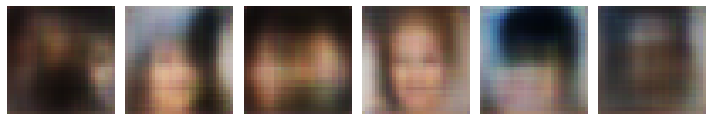

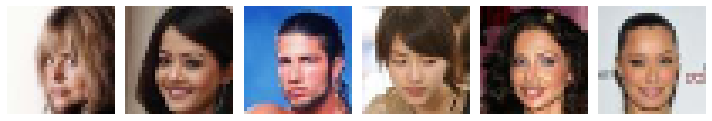

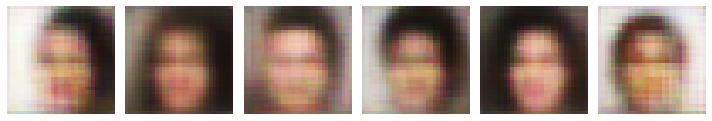

Epoch 2 of 20
Train Loss: 54182.2644
Val Loss: 53007.5075
Epoch 3 of 20
Train Loss: 53793.4359
Val Loss: 52943.5301
Epoch 4 of 20
Train Loss: 53575.8234
Val Loss: 52637.6963


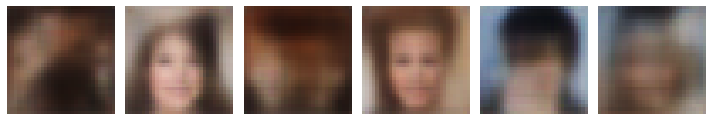

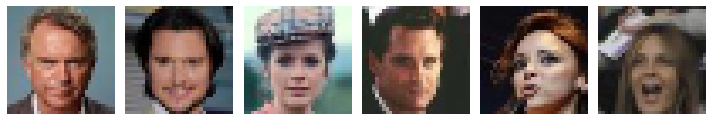

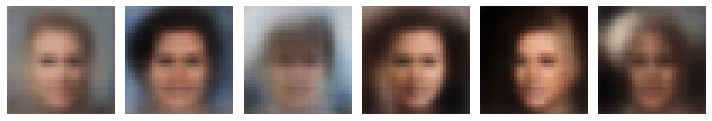

Epoch 5 of 20
Train Loss: 53441.8508
Val Loss: 52522.7590
Epoch 6 of 20
Train Loss: 53334.0787
Val Loss: 52399.9637
Epoch 7 of 20
Train Loss: 53252.7951
Val Loss: 52327.0599


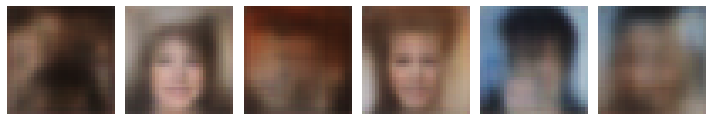

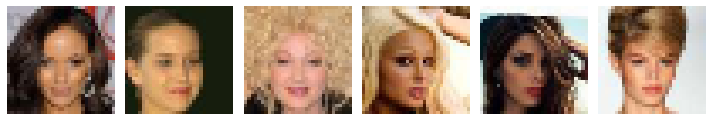

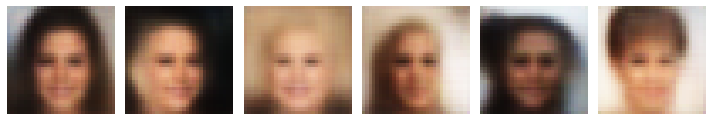

Epoch 8 of 20
Train Loss: 53177.5258
Val Loss: 52261.7148
Epoch 9 of 20
Train Loss: 53125.4377
Val Loss: 52297.8708
Epoch 10 of 20
Train Loss: 53070.5727
Val Loss: 52209.0455


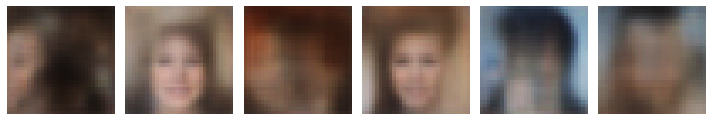

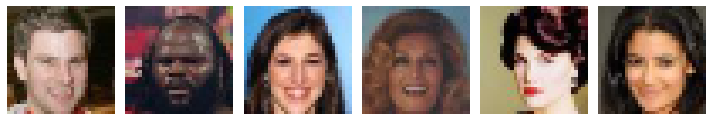

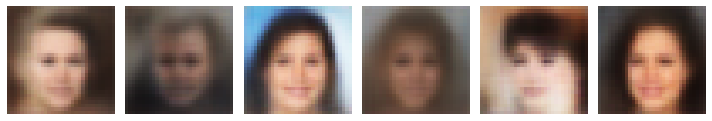

Epoch 11 of 20
Train Loss: 53021.9266
Val Loss: 52177.1104
Epoch 12 of 20
Train Loss: 52975.8283
Val Loss: 52162.5502
Epoch 13 of 20
Train Loss: 52938.6543
Val Loss: 52161.9219


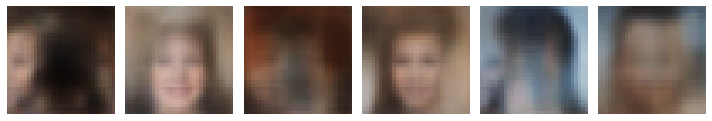

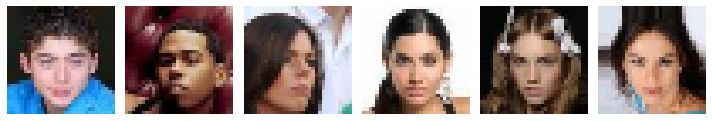

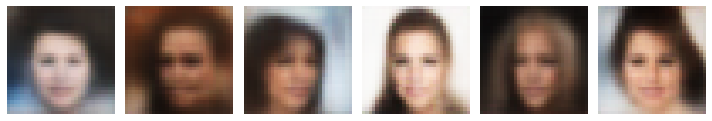

Epoch 14 of 20
Train Loss: 52896.1754
Val Loss: 52100.3649
Epoch 15 of 20
Train Loss: 52867.1789
Val Loss: 52017.0944
Epoch 16 of 20
Train Loss: 52829.2098
Val Loss: 52047.4535


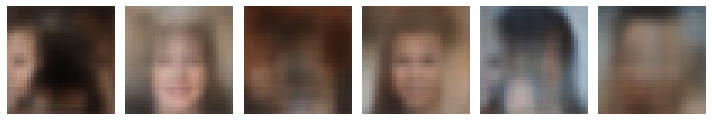

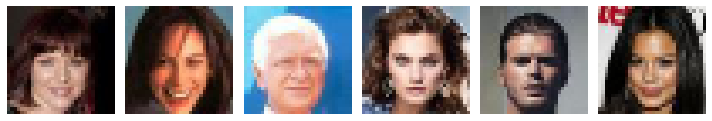

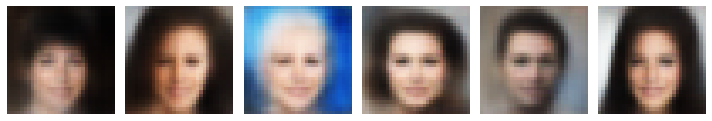

Epoch 17 of 20
Train Loss: 52798.1940
Val Loss: 52037.2973
Epoch 18 of 20
Train Loss: 52770.4414
Val Loss: 52014.4051
Epoch 19 of 20
Train Loss: 52748.0533
Val Loss: 52059.9832


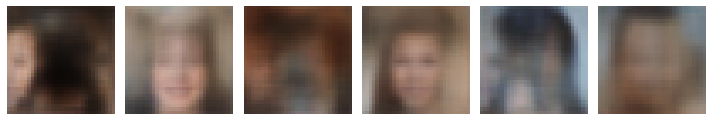

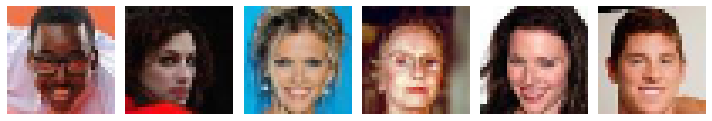

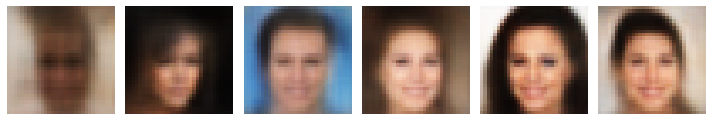

Epoch 20 of 20
Train Loss: 52723.5728
Val Loss: 52006.9529


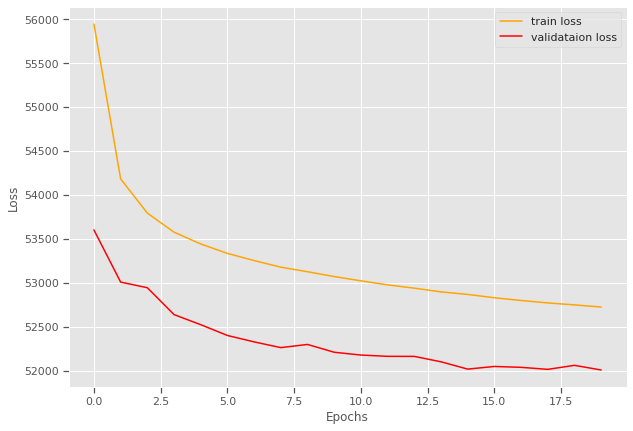

TRAINING COMPLETE


In [29]:
epochs = 20
optimizer = torch.optim.Adam(models_celeba['200d-det'].parameters(), lr=lr)
training(models_celeba['200d-det'],celeba_train_loader,celeba_test_loader,celeba_dataset,celeba_dataset,optimizer,callback=callback)

Epoch 1 of 7
Train Loss: 4770.1260
Val Loss: 3711.3621


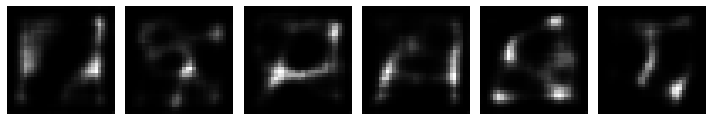

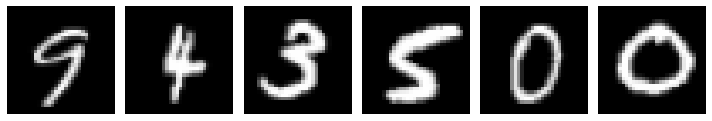

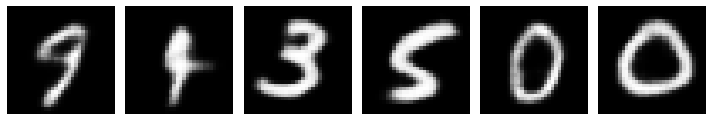

Epoch 2 of 7
Train Loss: 4010.3683
Val Loss: 3593.4482
Epoch 3 of 7
Train Loss: 3892.6136
Val Loss: 3553.1476
Epoch 4 of 7
Train Loss: 3833.5977
Val Loss: 3499.3091


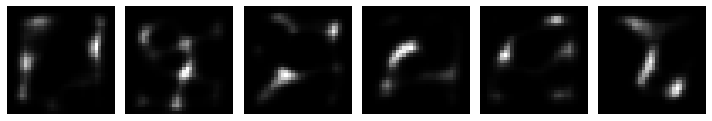

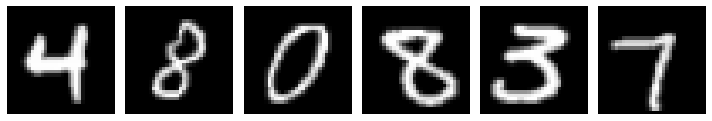

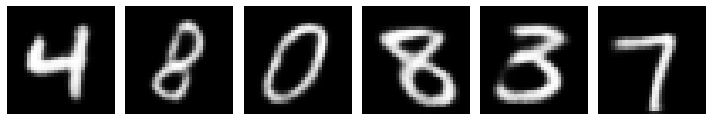

Epoch 5 of 7
Train Loss: 3791.6253
Val Loss: 3457.0571
Epoch 6 of 7
Train Loss: 3762.5106
Val Loss: 3445.8866
Epoch 7 of 7
Train Loss: 3739.7401
Val Loss: 3427.3865


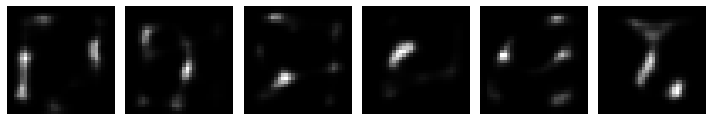

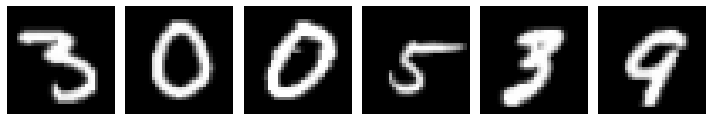

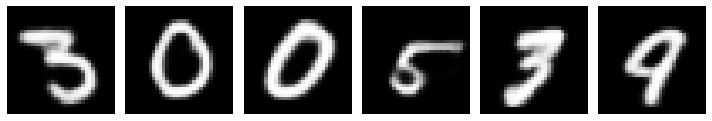

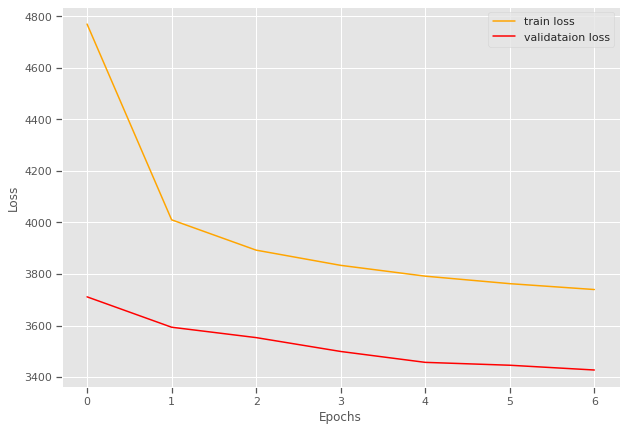

TRAINING COMPLETE


In [30]:
epochs = 7
optimizer = torch.optim.Adam(models_mnist['200d-det'].parameters(), lr=lr)
training(models_mnist['200d-det'],mnist_trainloader,mnist_testloader,mnist_trainset,mnist_testset,optimizer,True,callback)

In [31]:
def save(model,where):
  dump = {'latent_dim': model.latent_dim,
          'input_shape': model.input_shape,
          'state_dict': model.state_dict()}

  torch.save(dump, where)
save(models_mnist['200d-det'],'./outputs/mnist_200d_det.pt')

Epoch 1 of 5
Train Loss: 6798.7441
Val Loss: 6388.1470


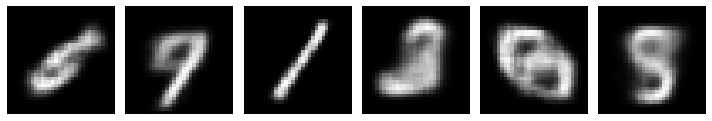

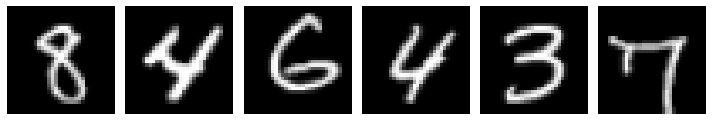

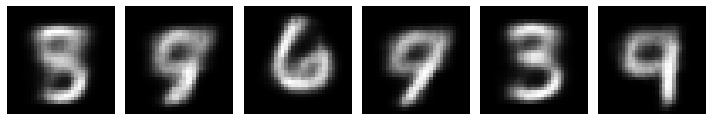

Epoch 2 of 5
Train Loss: 6325.0632
Val Loss: 6240.8792
Epoch 3 of 5
Train Loss: 6217.0049
Val Loss: 6157.4169
Epoch 4 of 5
Train Loss: 6151.0162
Val Loss: 6155.2078


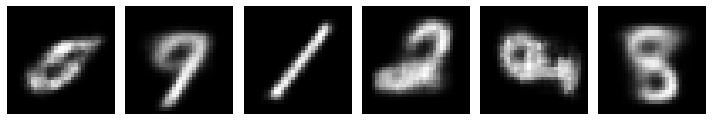

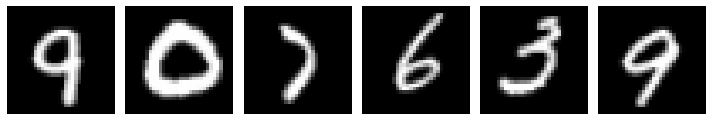

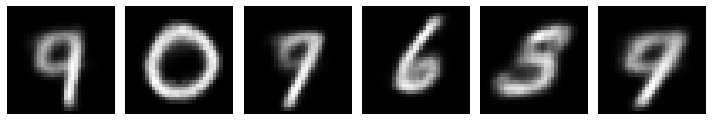

Epoch 5 of 5
Train Loss: 6101.7435
Val Loss: 6087.1099


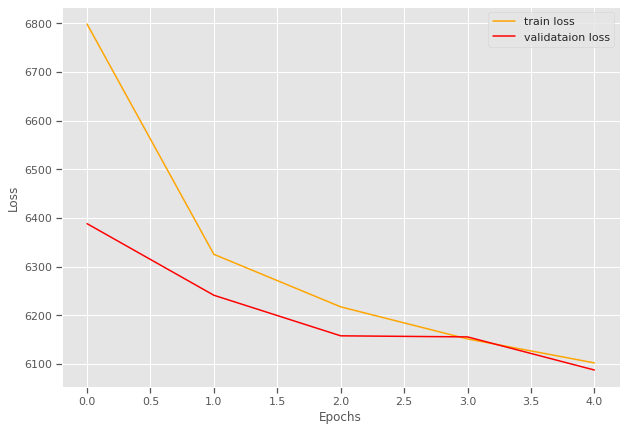

TRAINING COMPLETE


In [32]:
epochs = 5
optimizer = torch.optim.Adam(models_mnist['2d-det'].parameters(), lr=1e-3)
training(models_mnist['2d-det'],mnist_trainloader,mnist_testloader,mnist_trainset,mnist_testset,optimizer,True,callback)

Epoch 1 of 5
Train Loss: 7138.7120
Val Loss: 6687.1139


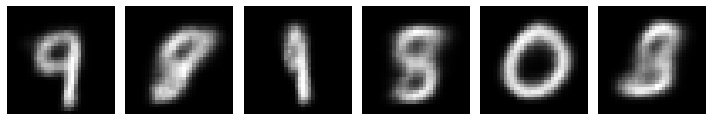

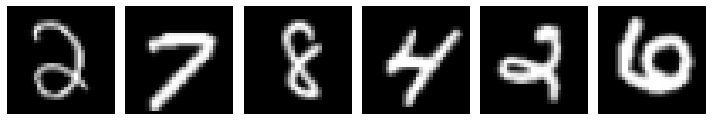

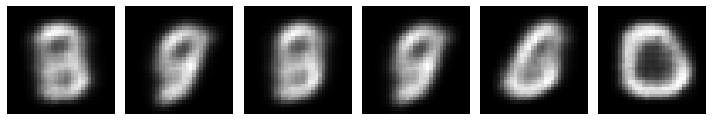

Epoch 2 of 5
Train Loss: 6628.1856
Val Loss: 6542.1278
Epoch 3 of 5
Train Loss: 6520.2785
Val Loss: 6465.5099
Epoch 4 of 5
Train Loss: 6452.1610
Val Loss: 6405.6575


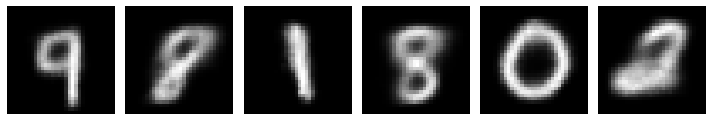

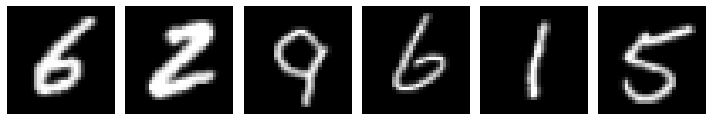

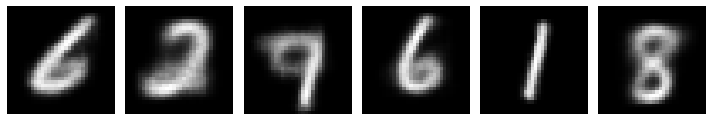

Epoch 5 of 5
Train Loss: 6407.5281
Val Loss: 6364.9836


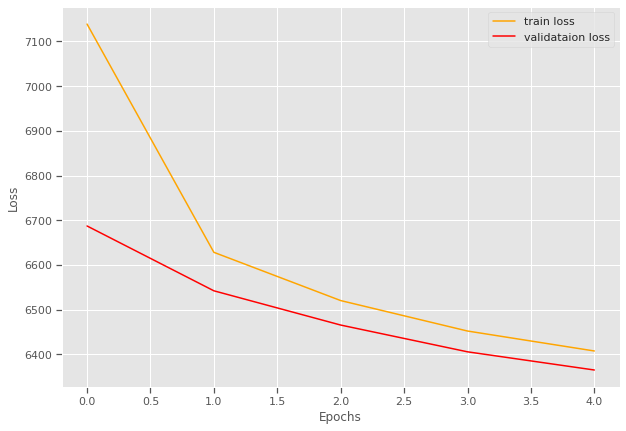

TRAINING COMPLETE


In [33]:
epochs = 5
optimizer = torch.optim.Adam(models_mnist['2d-stoch'].parameters(), lr=lr)
training(models_mnist['2d-stoch'],mnist_trainloader,mnist_testloader,mnist_trainset,mnist_testset,optimizer,True,callback)

# 2d Embeddings for mnist

In [34]:
N = int(len(mnist_testset))
images_mnist = torch.zeros(N,1,32,32)
labels_mnist = torch.zeros(N)
bs = mnist_testloader.batch_size
c = 0
for i,b in enumerate(mnist_testloader):
 images_mnist[i*bs:(i+1)*bs,:,:,:] = b[0]
 labels_mnist[i*bs:(i+1)*bs] = b[1]

print(images_mnist.shape)
print(labels_mnist.shape)


torch.Size([10000, 1, 32, 32])
torch.Size([10000])


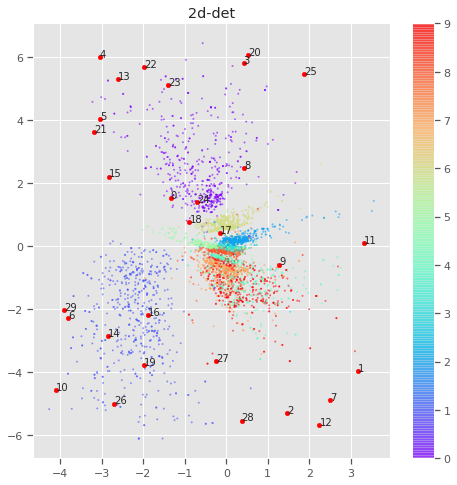

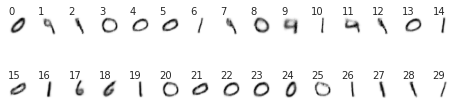

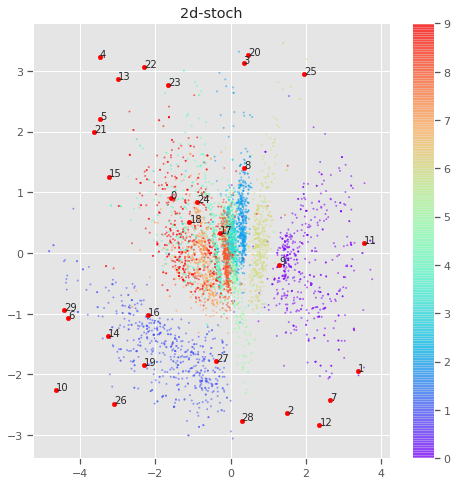

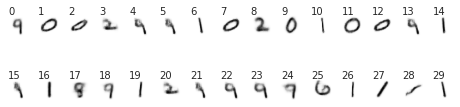

In [35]:
# generate images from random points in latent space
def sample_from_embeddings(model, n_to_show=5000):
  figsize = 8
  np.random.seed(42)
  example_idx = np.random.choice(range(N), n_to_show)
  example_images = images_mnist[example_idx].to(device)
  example_labels = labels_mnist[example_idx]
  z_points,_ = model.encode(example_images)
  z_points = z_points.cpu().detach().numpy()

  plt.figure(figsize=(figsize, figsize))
  #plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
  plt.scatter(z_points[:, 0] , z_points[:, 1], cmap='rainbow', c=example_labels, alpha=0.5, s=2)
  plt.colorbar()

  grid_size = 15
  grid_depth = 2
  np.random.seed(42)
  x_min = np.min(z_points[:,0]); x_max = np.max(z_points[:,0]);
  y_min = np.min(z_points[:,1]); y_max = np.max(z_points[:,1]);
  x = np.random.uniform(low=x_min, high=x_max, size=grid_size*grid_depth)
  y = np.random.uniform(low=y_min, high=y_max, size=grid_size*grid_depth)
  #x = np.random.normal(size = grid_size * grid_depth)
  #y = np.random.normal(size = grid_size * grid_depth)
  z_grid = np.array(list(zip(x, y)))
  t_z_grid = torch.FloatTensor(z_grid).to(device)
  reconst = model.decode(t_z_grid)
  reconst = reconst.cpu().detach()
  plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
  n = np.shape(z_grid)[0]
  for i in range(n):
    x = z_grid[i,0]
    y = z_grid[i,1]
    plt.text(x, y, i)
  plt.title(model.model_name)
  plt.show()

  fig = plt.figure(figsize=(figsize, grid_depth))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(grid_size*grid_depth):
      ax = fig.add_subplot(grid_depth, grid_size, i+1)
      ax.axis('off')
      #ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=8, ha='center', transform=ax.transAxes)
      ax.text(0.5, -0.35, str(i))
      ax.imshow(reconst[i,:][0, :, :],cmap = 'Greys')

sample_from_embeddings(models_mnist['2d-det'])
sample_from_embeddings(models_mnist['2d-stoch']) 

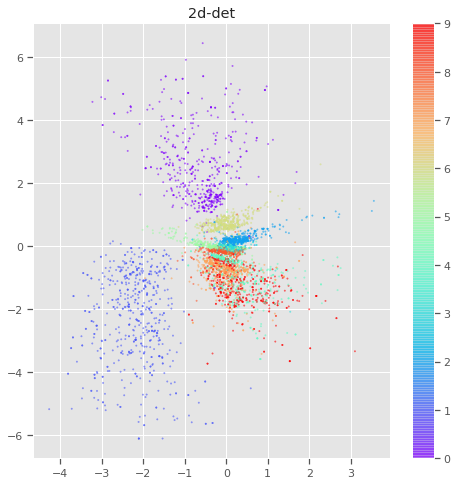

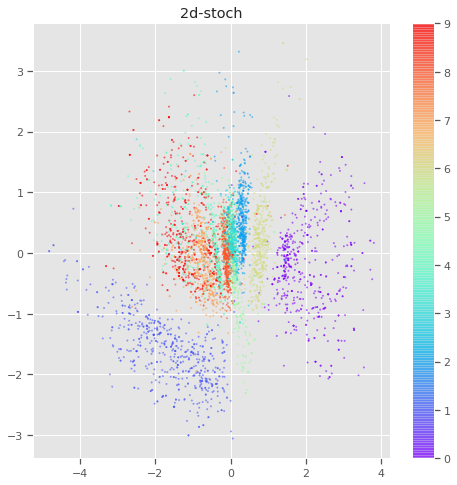

In [36]:
# color code latent points
from scipy.stats import norm

def show_2d_embeddings(model, n_to_show=5000, use_cdf=False):
  figsize = 8

  np.random.seed(42)
  example_idx = np.random.choice(range(N), n_to_show)
  example_images = images_mnist[example_idx].to(device)
  example_labels = labels_mnist[example_idx]

  z_points,_ = model.encode(example_images)
  z_points = z_points.cpu().detach()
  p_points = norm.cdf(z_points)

  plt.figure(figsize=(figsize, figsize))
  if use_cdf:
      plt.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , c= example_labels
              , alpha=0.5, s=5)
  else:
      plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
              , alpha=0.5, s=2)
  plt.colorbar()
  plt.title(model.model_name)
  plt.show()

show_2d_embeddings(models_mnist['2d-det'])
show_2d_embeddings(models_mnist['2d-stoch'])

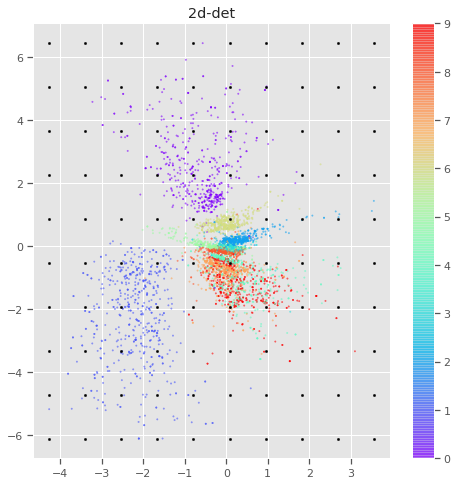

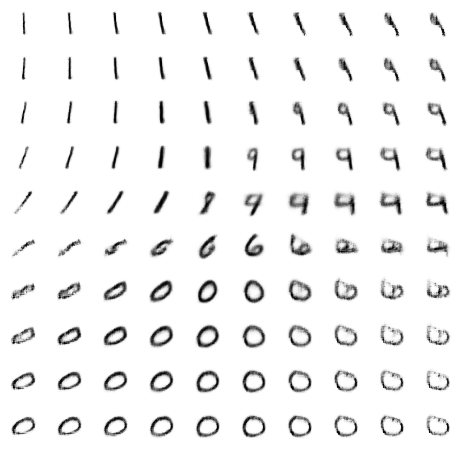

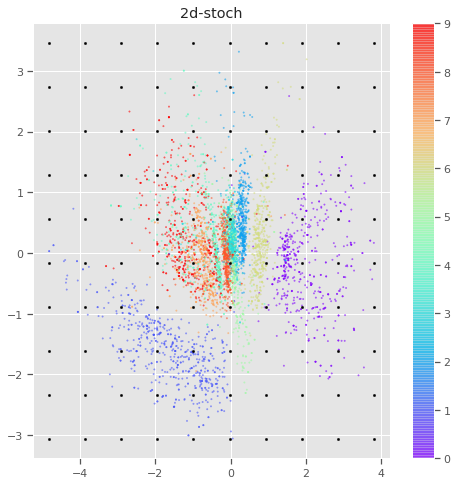

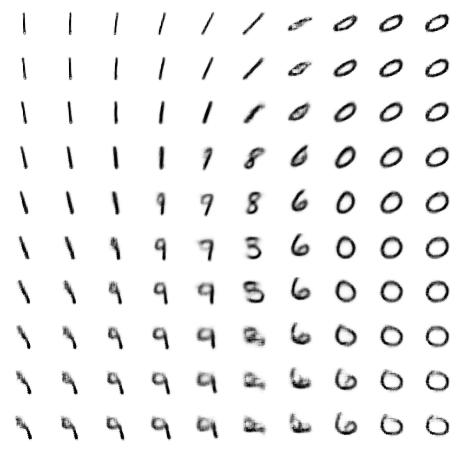

In [37]:
# Generate images from 2d grid

def generate_from_2d_grid(model):
  n_to_show = 5000 #500
  grid_size = 10
  figsize = 8
  np.random.seed(0)

  np.random.seed(42)
  example_idx = np.random.choice(range(N), n_to_show)
  example_images = images_mnist[example_idx].to(device)
  example_labels = labels_mnist[example_idx]
  z_points,_ = model.encode(example_images)
  z_points = z_points.cpu().detach().numpy()

  plt.figure(figsize=(figsize, figsize))
  plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
              , alpha=0.5, s=2)
  plt.colorbar()

  x_min = np.min(z_points[:,0]); x_max = np.max(z_points[:,0]);
  y_min = np.min(z_points[:,1]); y_max = np.max(z_points[:,1]);
  x = np.linspace(x_min, x_max, grid_size)
  y = np.linspace(y_min, y_max, grid_size)
  #x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
  #y = norm.ppf(np.linspace(0.01, 0.99, grid_size))
  xv, yv = np.meshgrid(x, y)
  xv = xv.flatten()
  yv = yv.flatten()
  z_grid = np.array(list(zip(xv, yv)))
  t_z_grid = torch.FloatTensor(z_grid).to(device)
  reconst = model.decode(t_z_grid).cpu().detach()

  plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
              , alpha=1, s=5)
  plt.title(model.model_name)
  plt.show()

  fig = plt.figure(figsize=(figsize, figsize))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)
  for i in range(grid_size**2):
      ax = fig.add_subplot(grid_size, grid_size, i+1)
      ax.axis('off')
      ax.imshow(reconst[i,:][0, :, :], cmap = 'Greys')
  plt.show()

generate_from_2d_grid(models_mnist['2d-det'])
generate_from_2d_grid(models_mnist['2d-stoch'])


# Reconstructions

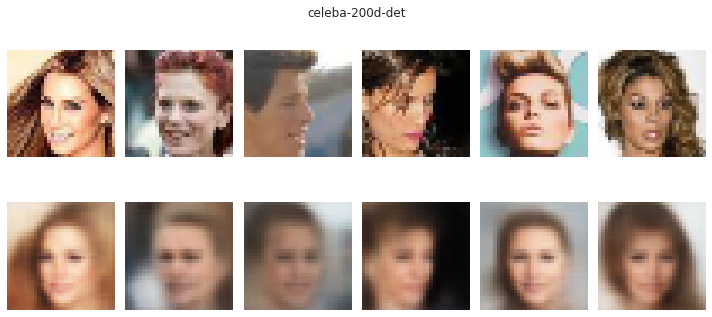

In [38]:
images = next(iter(celeba_train_loader)).to(device)
reconstruct_images(models_celeba['200d-det'],images,ttl='celeba-200d-det')

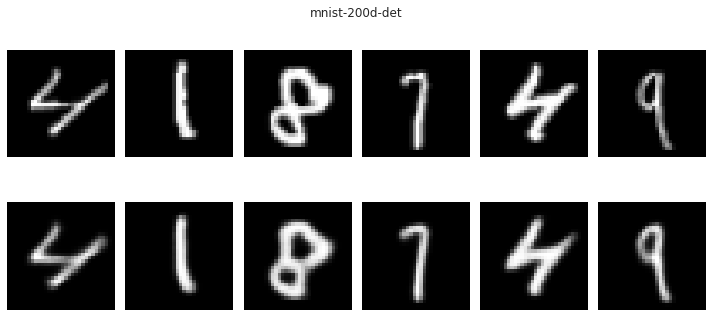

In [39]:
images = next(iter(mnist_trainloader))[0].to(device)
reconstruct_images(models_mnist['200d-det'],images,ttl='mnist-200d-det')

# Latent space analysis

Illustrate latent space embedding and arithmetic for  VAE on CelebA faces images
Code is based on 
 https://nbviewer.jupyter.org/github/davidADSP/GDL_code/blob/master/03_06_vae_faces_analysis.ipynb

In [40]:
# Make some wrapper functions so we can reuse code from
# https://github.com/davidADSP/GDL_code/blob/master/03_03_vae_faces_analysis.ipynb
  
N, H, W, C = images_celeba.shape
input_shape = (H,W,C)
INPUT_DIM = input_shape
DATA_FOLDER = ''
IMAGE_FOLDER = ''

def vae_encode(model, x):
    z,_ = model.encode(x)
    return z

def vae_decode(model, z_points):
    
    return model.decode(z_points)


In [41]:
print(input_shape)

(64, 64, 3)


In [42]:
att = pd.read_csv(csv_name)
att.head()


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,...,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [43]:
class ImageLabelLoader():
  def __init__(self, image_folder, target_size):
    self.image_folder = image_folder
    self.target_size = target_size
  
  def build(self, att, batch_size, label = None):

    if label:
      images_celeba,labels = self.get_images(att,label)
      data_loader = DataLoader(Celeba_ano_ds(images_celeba,labels),batch_size= batch_size,shuffle=True)
    else:
      images_celeba = self.get_images(att)
      data_loader = DataLoader(Celeba_ds(images_celeba),batch_size= batch_size,shuffle=True)
      
    return data_loader

  def get_images(self,df,label=None):
    H,W,C = self.target_size
    images = np.zeros((len(df), H, W, C), dtype=np.float32) # pre-allocate memory
    labels = np.zeros(len(df))
    for i in range(N):
      filename = df.iloc[i]['image_id']
      img = imread(filename) # numpy array of uint8
      images[i,:,:,:] = img / 255
      if label:
        labels[i]= df.iloc[i][label]
    if label:
      return images,labels
    else:
      return images


imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM)

## Arithmetic in latent space

In [44]:


def get_vector_from_label(model, label, batch_size=500, att=att):
    latent_dim = model.latent_dim
    data_loader = imageLoader.build(att, batch_size, label = label)

    #origin = np.zeros(shape = latent_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = latent_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = latent_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = latent_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = latent_dim, dtype = 'float32')

    current_vector = np.zeros(shape = latent_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')

    while(current_n_POS < 10000):

        batch = next(iter(data_loader))
        im = batch[0].to(device)
        attribute = batch[1]
        
        z = vae_encode(model, im)

        z = z.cpu().detach().numpy()
        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector   




In [45]:
def add_vector_to_images(example_images, model, feature_vec, att=att):
    factors = [-4,-3,-2,-1,0,1,2,3,4]
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        ])
    n_to_show = len(example_images)
    input = torch.zeros(n_to_show, C, 32, 32)
    for i in range(n_to_show):
        input[i,:,:,:] = transform(example_images[i])

    #factors = [-4,-2,0,2,4]
    print(input.shape)
    input = input.to(device)
    z_points = vae_encode(model, input)
    z_points = z_points.cpu().detach()
    for i in range(n_to_show):
      fig = plt.figure(figsize=(18, 8))
      counter = 1
      img = example_images[i].squeeze()
      sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
      sub.axis('off')        
      sub.imshow(img)
      counter += 1
      for factor in factors:
          changed_z_point = z_points[i] + feature_vec * factor
          changed_z_point = changed_z_point.to(device)
          changed_image = vae_decode(model, changed_z_point[None,:])[0]
          img = changed_image.cpu().detach()
          sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
          sub.axis('off')
          sub.imshow(torch.transpose(torch.transpose(img,0,2),0,1)[:, :, :])
          counter += 1
      plt.show()

In [46]:
print('Eyeglasses Vector')
model = models_celeba['200d-det']
eyeglasses_vec = get_vector_from_label(model, 'Eyeglasses')


Eyeglasses Vector
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
29    : 10.774    : 12.279    : 3.957    : 3.957
62    : 3.132    : 0.616    : 4.504    : 0.546
93    : 1.204    : 0.362    : 4.148    : -0.355
133    : 1.393    : 0.209    : 3.797    : -0.351
162    : 0.777    : 0.204    : 3.754    : -0.044
195    : 0.434    : 0.152    : 3.587    : -0.166
235    : 0.469    : 0.132    : 3.633    : 0.045
262    : 0.487    : 0.1    : 3.626    : -0.007
294    : 0.381    : 0.089    : 3.707    : 0.081
328    : 0.493    : 0.063    : 3.856    : 0.149
355    : 0.302    : 0.057    : 3.767    : -0.089
385    : 0.273    : 0.066    : 3.71    : -0.057
421    : 0.248    : 0.073    : 3.72    : 0.01
460    : 0.255    : 0.054    : 3.775    : 0.055
488    : 0.211    : 0.06    : 3.771    : -0.005
512    : 0.175    : 0.058    : 3.73    : -0.04
543    : 0.151    : 0.056    : 3.74    : 0.01
569    : 0.211    : 0.054    : 3.707    : -0.033
599    : 0.122    : 0.038    : 3.689    : -0.019


torch.Size([4, 3, 32, 32])


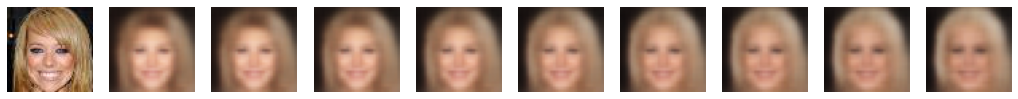

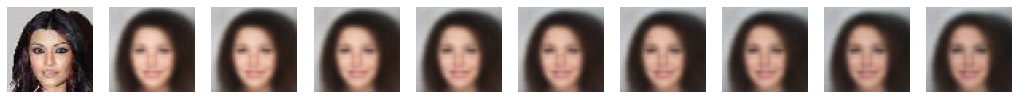

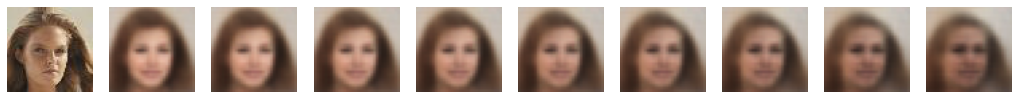

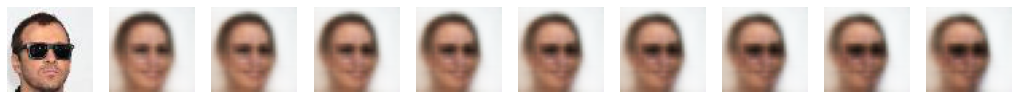

In [47]:

ndx = [112-1, 258-1, 238-1, 193-1] # blonde, black hair, brunette, male with glasses
add_vector_to_images(images_celeba[ndx], model, eyeglasses_vec)

In [48]:

print('Male Vector')
male_vec = get_vector_from_label(model, 'Male')


Male Vector
label: Male
images : POS move : NEG move :distance : 𝛥 distance
227    : 12.616    : 12.358    : 3.294    : 3.294
432    : 0.81    : 0.663    : 3.197    : -0.097
645    : 0.602    : 0.462    : 3.153    : -0.044
876    : 0.353    : 0.279    : 3.061    : -0.092
1098    : 0.275    : 0.262    : 3.065    : 0.003
1312    : 0.179    : 0.14    : 3.03    : -0.034
1524    : 0.155    : 0.165    : 3.056    : 0.026
1739    : 0.196    : 0.146    : 3.1    : 0.043
1955    : 0.146    : 0.15    : 3.119    : 0.02
2173    : 0.124    : 0.119    : 3.12    : 0.001
2367    : 0.15    : 0.111    : 3.12    : -0.001
2594    : 0.095    : 0.074    : 3.121    : 0.001
2794    : 0.105    : 0.078    : 3.092    : -0.029
3008    : 0.089    : 0.121    : 3.021    : -0.07
3225    : 0.072    : 0.064    : 3.031    : 0.009
3439    : 0.093    : 0.058    : 3.052    : 0.022
3648    : 0.064    : 0.063    : 3.043    : -0.01
3886    : 0.06    : 0.045    : 3.04    : -0.003
4100    : 0.062    : 0.059    : 3.054    : 0.014


torch.Size([4, 3, 32, 32])


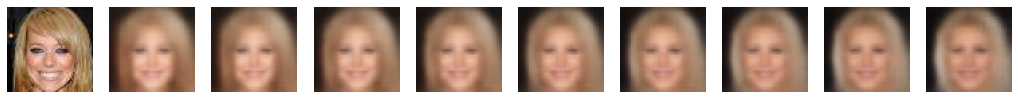

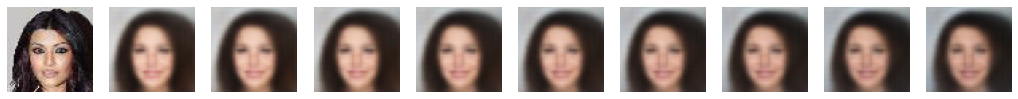

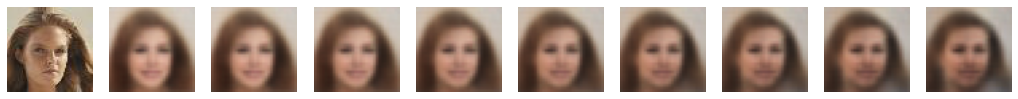

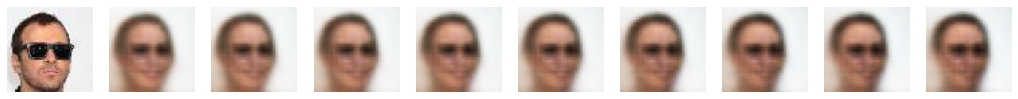

In [49]:
ndx = [112-1, 258-1, 238-1, 193-1] # blonde, black hair, brunette, male with glasses
add_vector_to_images(images_celeba[ndx], model, male_vec)

## Face interpolation

In [50]:
def morph_faces(start_image, end_image, model):
    #factors = np.arange(0, 1, 0.1)
    factors = np.arange(0, 1, 0.2)
    example_images = np.stack( (start_image, end_image), 0)
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        ])
    n = len(example_images)
    input = torch.zeros(n, C, 32, 32)
    for i in range(n):
        input[i,:,:,:] = transform(example_images[i])

    input = input.to(device)
    z_points = vae_encode(model, input)

    fig = plt.figure(figsize=(18, 8))

    counter = 1
    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1
    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_z_point = changed_z_point.to(device)
        changed_image = vae_decode(model, changed_z_point[None,:])[0]
        img = changed_image.cpu().detach()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(torch.transpose(torch.transpose(img,0,2),0,1)[:, :, :])

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)


    plt.show()


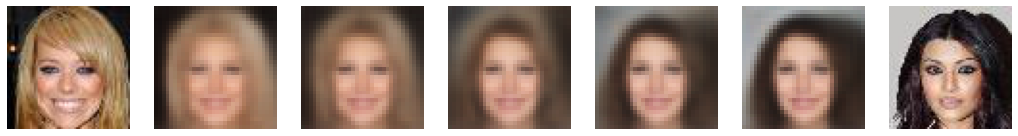

In [51]:
#model = model_dict_celeba['200d_stoch']
start_image = images_celeba[112-1] # blonde
end_image = images_celeba[258-1] # brunette
morph_faces(start_image, end_image, model)

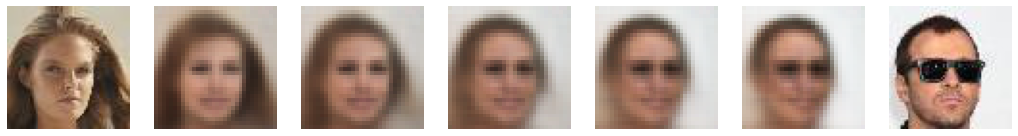

In [52]:
start_image = images_celeba[238-1] #female
end_image = images_celeba[193-1]  #male, glasses
morph_faces(start_image, end_image, model)